In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3
import scipy.stats as stats
import arviz as az

plt.style.use('ggplot')
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def post_grid_approx(grid_points = 100, success = 6, tosses = 9):
    p_grid = np.linspace(0, 1, grid_points)
    prob_p = np.repeat(5, grid_points)
    prob_data = stats.binom.pmf(success, tosses, p_grid)
    posterior = prob_data * prob_p
    posterior = posterior / np.sum(posterior)
    return p_grid, posterior

### Sampling from a grid-approximate posterior

The posterior is a bucket full of parameter values. Within the bucket, each value exists in proportion to its probability, such that values near the peak are much more common than those in the tails. Provided the bucket is well mixed, the resulting samples will have the same proportions as the exact posterior density.

In [3]:
p_grid, posterior = post_grid_approx(grid_points = 100, success = 6, tosses = 9)
samples = np.random.choice(p_grid, size=10000, replace=True, p=posterior)
kde = stats.gaussian_kde(samples)

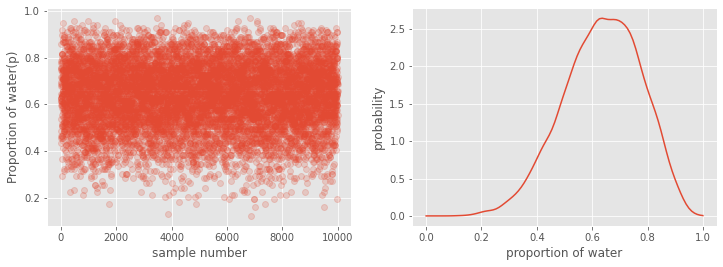

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(samples, 'o', alpha=0.2);
ax[0].set_xlabel('sample number')
ax[0].set_ylabel('Proportion of water(p)')
ax[1].plot(p_grid, kde(p_grid), label="Posterior by sampling");
ax[1].set_xlabel('proportion of water')
ax[1].set_ylabel('probability');

### Sampling to summarize

Once your model produces a posterior distribution, the model's work is done. It's necessary to summarize and interpret the posterior distribution. Common questions include'

    * How much posterior probability lies below some parameter value?
    * How much posterior probability lies betwen two parameter values?
    * Which parameter value marks the lower 5% of the posterior probability?
    * Which range of parameter values contains 90% of the posterior probability?
    * Which parameter value has highest posterior probability?
    
These simple questions can be usefully divided into questions about (1) intervals of *defined boundaries*, (2) questions about intervals of *defined probability mass* and (3) questions about *point estimates*. 

#### 1) Interval of defined boundaries

The posterior probability that the proportion of water is less than 0.5

In [5]:
# Add up posterior probability where p < 0.5
np.sum(posterior[p_grid < 0.5])

0.17183313110747478

We can perform the same calculation using samples from posterior. All you have to do is similarly add up all of the samples below 0.5, but also divide the resulting count by the total number of samples. In other words, find the frequency of parameter values below 0.5

In [6]:
np.sum(samples < 0.5) / 1e4

0.1713

Using the same approach, you can ask how much posterior probability lies between 0.5 and 0.75

In [7]:
np.sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6124

#### 2) Intervals of defined maas

CONFIDENCE INTERVAL == CREDIBLE INTERVAL == COMPATIBILITY INTERVAL
These posterior intervals report 2 parameter values that contain between them a specified amount of posterior probability, a probability maas. For this type of interval, it's easier to find the answer by using samples from the posterior than by using a grid approximation.

Suppose you want to know the boundaries of the lower 80% posterior probability.

In [8]:
np.quantile(samples, 0.8)

0.7575757575757577

Middle quantile 80% lies between 10th percentile and the 90th percentile.

In [9]:
q = np.quantile(samples, [0.1, 0.9])

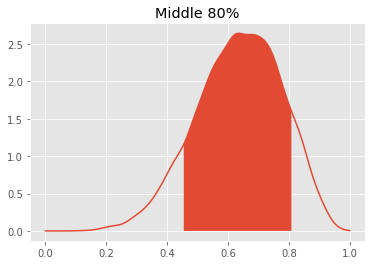

In [10]:
grid_80th = p_grid[(p_grid > q[0]) & (p_grid < q[1])]
plt.plot(p_grid, kde(p_grid), label="Posterior by sampling");
plt.fill_between(grid_80th, kde(grid_80th))
plt.title('Middle 80%');

#### 3) Point Estimates

It is very common for scientists to report the parameter value with highest posterior probability, a maximum of posteriori (MAP) estimate. You can easily compute the MAP if you have the posterior or samples. 

For example, let calculate the proportion of water if 3 tosses return the same water.

In [11]:
p_grid, posterior = post_grid_approx(grid_points=100, success=3, tosses=3)
samples = np.random.choice(p_grid, size=10000, replace=True, p=posterior)

Then we can calculate the MAP in this example

In [12]:
p_grid[np.argmax(posterior)]

1.0

In [13]:
stats.mode(samples)[0][0]

1.0

In [14]:
print('Mean = {}'.format(np.mean(samples)))
print('Median = {}'.format(np.median(samples)))

Mean = 0.8039111111111111
Median = 0.8484848484848485


One principled way to go beyond using the entire posterior as the estimate is to choose a **LOSS FUNCTION**. A loss function is a rule that tells you the cost associated with using any particular point estimate. The key insight is that *different loss functions imply different point estimates*. 

It turns out that the parameter value that maximizes expected winnings (minimizes expected loss) is the median of the posterior distribution. 

We could try to calculate the loss using the entire posterior distribution.

In [15]:
lossfn = lambda p: np.sum(posterior * np.abs(p - p_grid))
vlossfn = np.vectorize(lossfn)
lossfn(0.5)

0.3162687480869299

All the code above does is compute the weighted average loss, where each loss is weighted by its corresponding posterior probability. We vectorize the loss function to calculate all possible decision. 

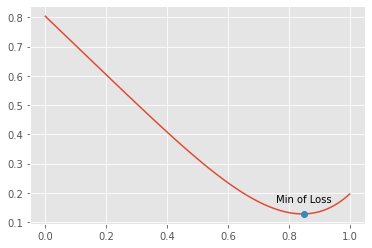

In [16]:
loss_all_decisions = vlossfn(p_grid)
idx_min = np.argmin(loss_all_decisions)

plt.plot(p_grid, loss_all_decisions)
plt.plot(p_grid[idx_min], loss_all_decisions[idx_min], 'o')
plt.text(p_grid[idx_min], loss_all_decisions[idx_min]+0.05, s='Min of Loss', 
         horizontalalignment='center', verticalalignment='center');

The 2 most common examples are the absolute loss (as above), which leads to the **median** as the point estimate, and the quadratic loss $(d-p)^2$, which leads to the **posterior mean** as the point estimate. When the posterior distribution is symmetrical and normal-looking, then the median and mean converge to the same point. 

### Sampling to simulate prediction

Generating implied observations from a model is useful for at least four distinct reasons

    (1) *Model design*: Seeing what the model expects, before the data arrive, is the best way to understand the implications of the prior.
    (2) *Model checking*: After a model is updated using data, it is worth simulating implied observations, to check both whether the fit worked correctly and to investigate model behavior
    (3) *Software validation*
    (4) *Research design*
    (5) *Forecasting*

In [17]:
stats.binom.pmf([0,1,2], n=2, p=0.7)

array([0.09, 0.42, 0.49])

In [18]:
dummy_w = stats.binom.rvs(2, 0.7, size=100000, random_state=2304)
(unique, counts) = np.unique(dummy_w, return_counts=True)
print(unique, counts/1e5)

[0 1 2] [0.09102 0.4192  0.48978]
